In [1]:
# automatically reload dependencies and repository content so that kernel need not be restarted
%load_ext autoreload
%autoreload 2

In [2]:
import torch


device = None
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


In [3]:
from image_dataset import ImageDataset
from data_augmentation import DataAugmentation

dataAugmentation = DataAugmentation()
dataset = ImageDataset(dataAugmentation = dataAugmentation)

In [4]:
trainIds = range(1,19001)

In [5]:
from data_balancer import DataBalancer

dataBalancer = DataBalancer()

#trainIds = dataBalancer.balanceData(trainIds, 80000-19000, trainIds)

In [6]:
trainDataset = ImageDataset(trainIds, dataAugmentation=dataAugmentation)
valDataset = ImageDataset(range(19001,20001))

In [28]:
from reseption_net import ReseptionNet
from convolution_components import BasicConv2d, MaxPooling, IdentityConv2d

torch.cuda.empty_cache()

basicInceptionConfig = {
    "branches": [
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 6,
                    "kernelSize": 3,
                    "padding": 1,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 8,
                    "padding": 2,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        },
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 6,
                    "kernelSize": 5,
                    "padding": 2,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 8,
                    "padding": 2,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        },
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 6,
                    "kernelSize": 7,
                    "padding": 3,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 8,
                    "padding": 2,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        }
        
    ],
    "shortcut": {
        "enabled": False,
        "convolution": IdentityConv2d,
        "kernelSize": 1,
        "padding": 0,
        "stride": 4,
        "dilation": 1,
        "grouping": True,
    }
}

combinerConfig = {
    "branches": [
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 2,
                    "kernelSize": 14,
                    "padding": 0,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
            ]
        }
    ],
    "shortcut": {
        "enabled": False,
        "convolution": IdentityConv2d,
        "kernelSize": 1,
        "padding": 0,
        "stride": 14,
        "dilation": 1,
        "grouping": True,
    }
}
    
config = {
    "inceptions": [
        {
            "config": basicInceptionConfig,
            "amount": 2,
        },
        {
            "config": combinerConfig,
            "amount": 1,
        },
    ],
    "inChannels": 3,
    "inDimensions": (224, 224),
    "hiddenLayers": {
        "neurons": []
    },
    "outputs": 14,
}

model = ReseptionNet(device, config)
print("Parameters:", model.getNumberOfParameters())

inception 1 iteration 1 layer output dimensions 54 * 56 * 56 = 169344
inception 1 iteration 2 layer output dimensions 972 * 14 * 14 = 190512
inception 2 iteration 1 layer output dimensions 1944 * 1 * 1 = 1944
Parameters: 510296


In [7]:
torch.cuda.empty_cache()
model = torch.load("shallow_model.pkl")

In [36]:
from train_model import train_model

model = train_model(
    model,
    trainDataset,
    valDataset,
    device,
    numberOfEpochs = 1
)

Epoch 1/1
----------

Training...

Progress: 100%

train Loss: 0.2041 Acc: 0.9260

Validating...

Progress: 100%

val Loss: 0.1987 Acc: 0.9243

Training complete in 24m 37s
Best val Acc: 0.924286


In [16]:
torch.save(model, 'shallow_model.pkl')
#torch.cuda.empty_cache()

In [40]:
import eval_model

decisionThreshold = 0.5

print("Validation:")
yHats, yTrues = eval_model.test_model(model, valDataset, device, decisionThreshold=decisionThreshold)
for metric in ['precision', 'recall', 'f1', 'accuracy']:
    print("{}: {}".format(metric, eval_model.get_metric(yTrues, yHats, metric)))

Validation:
precision: 0.43283582089552236
recall: 0.20361083249749248
f1: 0.27694406548431105
accuracy: 0.9242857142857143


Validation images:



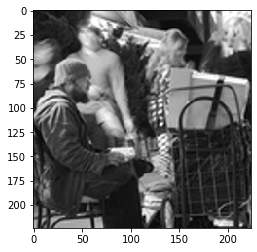

True labels:  ['male', 'people', 'female']
Predicted labels: []



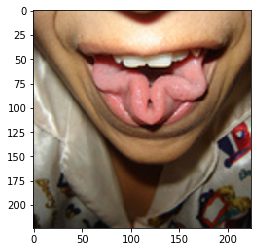

True labels:  ['people']
Predicted labels: []



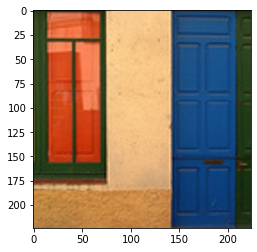

True labels:  []
Predicted labels: ['people', 'female']



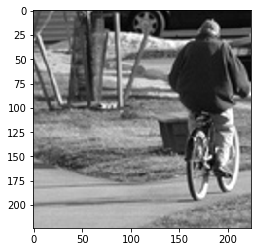

True labels:  ['male', 'people']
Predicted labels: []



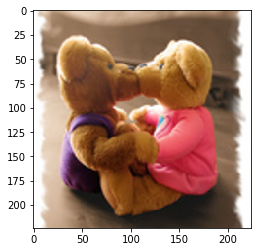

True labels:  []
Predicted labels: ['portrait']



In [38]:
from example_prediction_shower import showExamplePredictions

print("Validation images:")
print()
showExamplePredictions(model, valDataset, device, 5, decisionThreshold=decisionThreshold)

Training images:



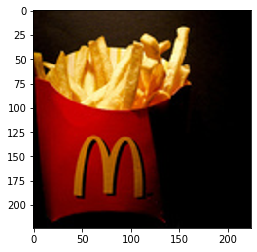

True labels:  []
Predicted labels: ['flower']



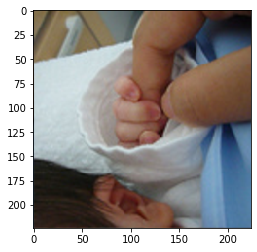

True labels:  []
Predicted labels: []



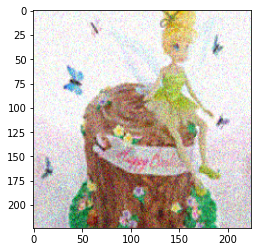

True labels:  []
Predicted labels: []



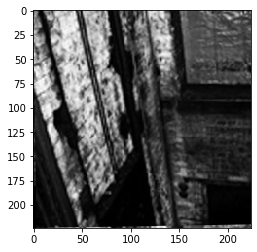

True labels:  []
Predicted labels: ['people']



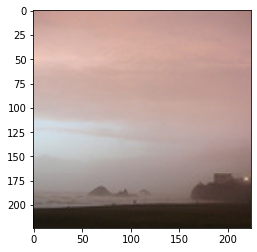

True labels:  []
Predicted labels: []



In [39]:
print("Training images:")
print()
showExamplePredictions(model, trainDataset, device, 5, decisionThreshold=decisionThreshold)